In [55]:
import numpy as np

def convert_w2c(matrix_world_to_camera, frame, point):

    point_4d = np.resize(point, 4)
    point_4d[3] = 1
    co_local = matrix_world_to_camera.dot(point_4d)
    z = -co_local[2]

    if z == 0.0:
            return np.array([0.5, 0.5, 0.0])
    else:
        for i in range(3):
            frame[i] =  -(frame[i] / (frame[i][2]/z))

    min_x, max_x = frame[2][0], frame[1][0]
    min_y, max_y = frame[1][1], frame[0][1]

    x = (co_local[0] - min_x) / (max_x - min_x)
    y = (co_local[1] - min_y) / (max_y - min_y)

    return np.array([x,y,z])

In [62]:
import pickle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2

ANNOTATIONS_PATH = "../../image2sdf/input_images_validation/annotations.pkl"
MATRIX_PATH = "../../image2sdf/input_images_validation/matrix_w2c.pkl"
IMAGES_PATH = "../../image2sdf/input_images_validation/images/"
annotations_file = open(ANNOTATIONS_PATH, "rb")
matrix_file = open(MATRIX_PATH, "rb")
annotations = pickle.load(annotations_file)
matrix_world_to_camera = pickle.load(matrix_file)

In [80]:
# scene_id = list(annotations.keys())[0]
scene_id = next(iter(annotations.keys()))
image_id = 4
image_pth = IMAGES_PATH + scene_id + '/' + str(image_id) + '.png'
im = imageio.imread(image_pth)
loc_2d = annotations[scene_id][image_id]['2d'].copy()
loc_3d = annotations[scene_id][image_id]['3d'].copy()
frame = annotations[scene_id][image_id]['frame']


num_interp = 50
loc_mid_3d = np.empty([num_interp,4,3])
for i in range(num_interp):
    loc_mid_3d[i,0,:] = loc_3d[0,:] * (1-i/(num_interp-1)) + loc_3d[4,:] * i/(num_interp-1)
    loc_mid_3d[i,1,:] = loc_3d[1,:] * (1-i/(num_interp-1)) + loc_3d[5,:] * i/(num_interp-1)
    loc_mid_3d[i,2,:] = loc_3d[2,:] * (1-i/(num_interp-1)) + loc_3d[6,:] * i/(num_interp-1)
    loc_mid_3d[i,3,:] = loc_3d[3,:] * (1-i/(num_interp-1)) + loc_3d[7,:] * i/(num_interp-1)

loc_mid_2d = np.empty_like(loc_mid_3d)
for i in range(num_interp):
    for j in range(4):
      loc_mid_2d[i,j,:] = convert_w2c(matrix_world_to_camera, frame, loc_mid_3d[i,j,:]) 


###### y coordinate is inverted #####
loc_2d[:,1] = 1- loc_2d[:,1]
loc_2d[:,0] = loc_2d[:,0] * 450
loc_2d[:,1] = loc_2d[:,1] * 300


loc_mid_2d[:,:,1] = 1- loc_mid_2d[:,:,1]
loc_mid_2d[:,:,0] = loc_mid_2d[:,:,0] * 450
loc_mid_2d[:,:,1] = loc_mid_2d[:,:,1] * 300

In [70]:
a = []
a.append(2)
a.append(2)
a.append(2)
a.append(2)

In [81]:
list(annotations.keys())

TypeError: 'list' object is not callable

In [71]:
a

[2, 2, 2, 2]

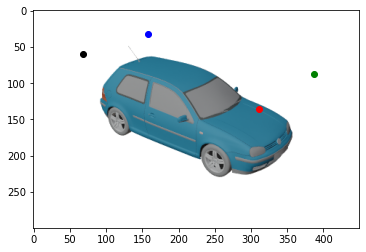

In [ ]:
interp = 1

plt.figure()
plt.imshow(im)
plt.scatter(x = loc_2d[3,0], y = loc_2d[3,1], c = 'r')
plt.scatter(x = loc_2d[2,0], y = loc_2d[2,1], c = 'g')
plt.scatter(x = loc_2d[6,0], y = loc_2d[6,1], c = 'b')
plt.scatter(x = loc_2d[7,0], y = loc_2d[7,1], c = 'k')
# plt.scatter(x = loc_2d[4:,0] * 450, y = loc_2d[4:,1] * 300, c = 'g')
# plt.scatter(x = loc_mid_2d[interp,:,0] * 450, y = loc_mid_2d[interp,:,1] * 300, c = 'b')

In [58]:
height, width, depth = 50, 50, 100

NameError: name 'loc_2d' is not defined

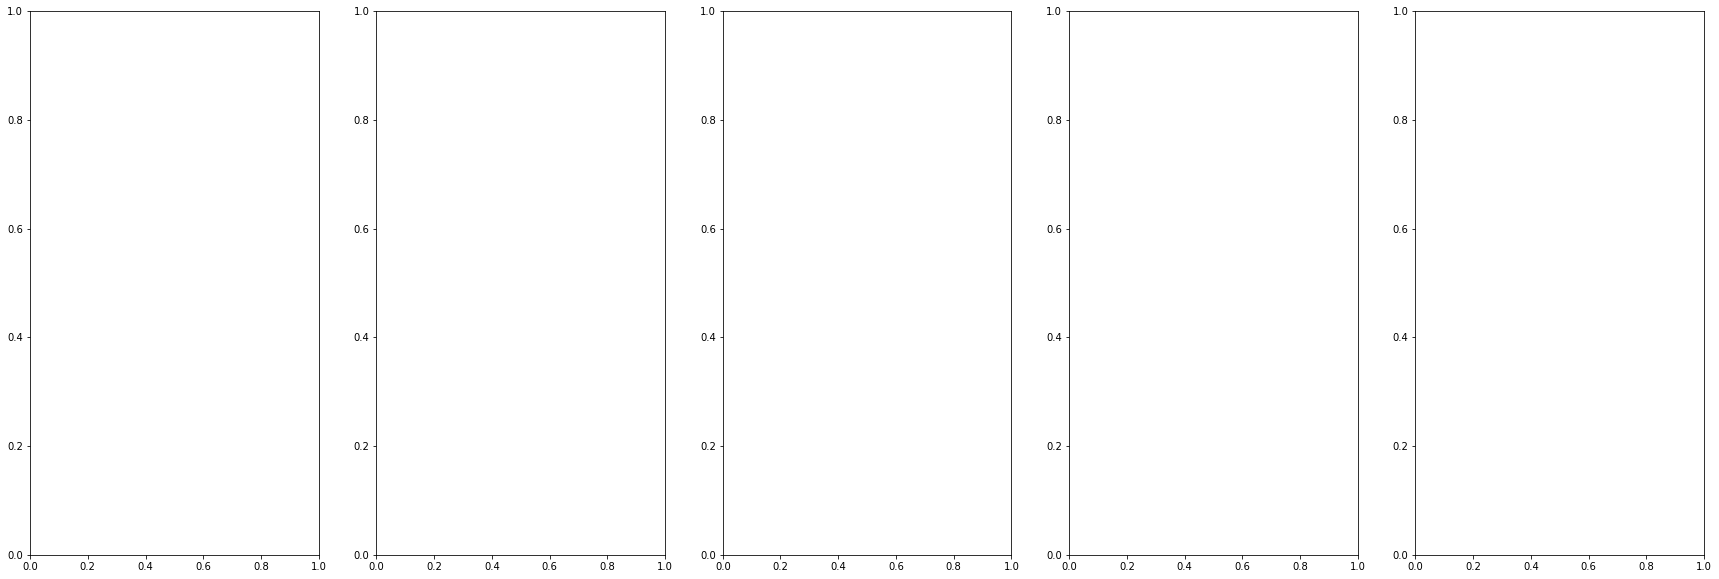

In [59]:
fig, axs = plt.subplots(1,5, figsize=(30,10))

# front
src = np.array([loc_2d[0,:2],loc_2d[1,:2],loc_2d[2,:2],loc_2d[3,:2]]).copy()
dst = np.array([[0,height],[width,height],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[0].imshow(cv2.warpPerspective(im, h, (width,height)))


src = np.array([loc_2d[1,:2],loc_2d[5,:2],loc_2d[6,:2],loc_2d[2,:2]]).copy()
dst = np.array([[0,height],[depth,height],[depth,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[1].imshow(cv2.warpPerspective(im, h, (depth,height)))


src = np.array([loc_2d[5,:2],loc_2d[4,:2],loc_2d[7,:2],loc_2d[6,:2]]).copy()
dst = np.array([[0,height],[width,height],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[2].imshow(cv2.warpPerspective(im, h, (width,height)))


src = np.array([loc_2d[4,:2],loc_2d[0,:2],loc_2d[3,:2],loc_2d[7,:2]]).copy()
dst = np.array([[0,height],[depth,height],[depth,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[3].imshow(cv2.warpPerspective(im, h, (depth,height)))


src = np.array([loc_2d[3,:2],loc_2d[2,:2],loc_2d[6,:2],loc_2d[7,:2]]).copy()
dst = np.array([[0,depth],[width,depth],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[4].imshow(cv2.warpPerspective(im, h, (width,depth)))

In [ ]:
height, width = 25, 25
# fig, axs = plt.subplots(1,num_interp, figsize=(30,10))
for i in range(num_interp):
    src = np.array([loc_mid_2d[i,0,:2],loc_mid_2d[i,1,:2],loc_mid_2d[i,2,:2],loc_mid_2d[i,3,:2]])
    src[:,0] = src[:,0] * 450
    src[:,1] = src[:,1] * 300
    dst = np.array([[0,height],[width,height],[width,0],[0,0]])
    h, mask = cv2.findHomography(src, dst)

    # axs[i].imshow(cv2.warpPerspective(im, h, (width,height)))


In [ ]:
a  =cv2.warpPerspective(im, h, (width,height))

In [ ]:
np.transpose(a,[2,0,1]).shape

In [2]:
import pickle
import matplotlib.pyplot as plt
with open("/home/loic/MasterPDM/image2sdf/logs/encoder/log.txt", "rb") as fp:
    avrg_loss = pickle.load(fp)

In [4]:
import numpy as np

Text(0, 0.5, 'L2 loss')

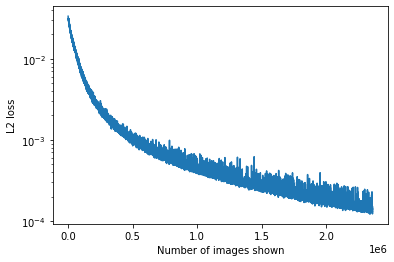

In [12]:

plt.semilogy(np.arange(len(avrg_loss)) * 10,avrg_loss[:])
plt.xlabel("Number of images shown")
plt.ylabel("L2 loss")

In [23]:
import torch
a = torch.tensor(np.array([1,2,3,4,5]), dtype=torch.float)
b = torch.tensor(np.array([1,3,3,8,5]), dtype=torch.float)


In [28]:
a.dot(b)

tensor(73.)

In [34]:
def cosine_distance(a,b):
    return a.dot(b)/(a.norm() * b.norm())

In [35]:
cosine_distance(a,b)

tensor(0.9472)

In [47]:
num_scene = 3
num_image_per_scene = 3

In [54]:

for scene_id_1 in range(num_scene):
    for scene_id_2 in range(scene_id_1, num_scene):
        for vec1 in range(num_image_per_scene-1):
        # if scene_id_1 == scene_id_2:
            print(f"cosine distance for scene {scene_id_1} and {scene_id_2}")
            for vec2 in range(vec1 + 1, num_image_per_scene):
                dist = 2
                # if scene_id_1 == scene_id_2:
                print(f"cosine distance between vec {vec1} and {vec2}: {dist}")

cosine distance for scene 0 and 0
cosine distance between vec 0 and 1: 2
cosine distance between vec 0 and 2: 2
cosine distance for scene 0 and 0
cosine distance between vec 1 and 2: 2
cosine distance for scene 0 and 1
cosine distance between vec 0 and 1: 2
cosine distance between vec 0 and 2: 2
cosine distance for scene 0 and 1
cosine distance between vec 1 and 2: 2
cosine distance for scene 0 and 2
cosine distance between vec 0 and 1: 2
cosine distance between vec 0 and 2: 2
cosine distance for scene 0 and 2
cosine distance between vec 1 and 2: 2
cosine distance for scene 1 and 1
cosine distance between vec 0 and 1: 2
cosine distance between vec 0 and 2: 2
cosine distance for scene 1 and 1
cosine distance between vec 1 and 2: 2
cosine distance for scene 1 and 2
cosine distance between vec 0 and 1: 2
cosine distance between vec 0 and 2: 2
cosine distance for scene 1 and 2
cosine distance between vec 1 and 2: 2
cosine distance for scene 2 and 2
cosine distance between vec 0 and 1: 2
co

In [51]:
a = torch.tensor([1])
b = torch.tensor([2])

In [52]:
list = []
list.append(a)
list.append(a)
list.append(a)
list.append(a)
list.append(a)
list.append(b)
print(np.mean(list))

ValueError: only one element tensors can be converted to Python scalars